# Machine Learning (COSC 522)
## Project 5

In [1]:
# Import Jupyter Widgets
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display
# Clone the repository if you're in Google Collab
# from google.colab import drive
# drive.mount('/content/drive', force_remount=False)
def mount_and_change_dir(is_collab: bool = False):
    # Set working directory
    project_path = '/content/drive/MyDrive/Projects/UTK/COSC522'
    os.chdir(project_path)
    print(os.listdir(project_path))
       
print("Are you on Google Collab?")
btn = widgets.Button(description="Yes")
btn.on_click(mount_and_change_dir)
display(btn)

Are you on Google Collab?


Button(description='Yes', style=ButtonStyle())

## Import libraries

In [2]:
# Imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_formats = ['png']

import numpy as np
import matplotlib.pyplot as plt
from time import time
from pprint import pprint
import seaborn as sns
from scipy.stats import uniform, gaussian_kde, norm
from typing import *
from tqdm.notebook import tqdm

from custom_libs import ColorizedLogger

sns.set_style('darkgrid')

logger = ColorizedLogger('Project4', 'yellow')

### Import custom classes

In [43]:
# Located in <project root>/custom_libs/Project4
import custom_libs.Project4.models as p4_models
import custom_libs.Project4.plotter as p4_pl
# Located in <project root>/custom_libs/Project5
import custom_libs.Project5.models as p5_models
import custom_libs.Project5.data_loader as dl
import custom_libs.Project5.plotter as p5_pl

### Load the two datasets and Preprocess them

In [9]:
# Create a Data Loader
datasets = ['pima']
data_loader = dl.DataLoader(datasets=datasets, data_folder='data')
# Standarize Pima
data_loader.standarize('pima')

In [10]:
# Get the two datasets
datasets = data_loader.get_datasets()
pima_tr, pima_te, pima_val = datasets['pima']
# Print their statistics
data_loader._print_statistics(pima_tr, 'pima_tr')
data_loader._print_statistics(pima_te, 'pima_te')
data_loader._print_statistics(pima_val, 'pima_val')

2021-11-14 12:25:19 Data Loader  INFO     -- pima_tr --
2021-11-14 12:25:19 Data Loader  INFO     	Shape: (140, 8)
2021-11-14 12:25:19 Data Loader  INFO     	Type: float64
2021-11-14 12:25:19 Data Loader  INFO     	Mean:
2021-11-14 12:25:19 Data Loader  INFO     		[5.63041677e-17 1.11022302e-17 1.15780401e-16 8.56457762e-17] (..)
2021-11-14 12:25:19 Data Loader  INFO     	Max:
2021-11-14 12:25:19 Data Loader  INFO     		[3.12209009 2.32024231 3.10148276 5.76466197] (..)
2021-11-14 12:25:19 Data Loader  INFO     	Min:
2021-11-14 12:25:19 Data Loader  INFO     		[-1.05205491 -2.21574128 -2.76839074 -1.67476715] (..)
2021-11-14 12:25:19 Data Loader  INFO     	Head:
2021-11-14 12:25:19 Data Loader  INFO     		[ 0.43871116 -0.07552367  0.16654601  0.83290559] (..)
2021-11-14 12:25:19 Data Loader  INFO     -- pima_te --
2021-11-14 12:25:19 Data Loader  INFO     	Shape: (332, 8)
2021-11-14 12:25:19 Data Loader  INFO     	Type: float64
2021-11-14 12:25:19 Data Loader  INFO     	Mean:
2021-11-1

#### One Hot Encode the target vectors of Pima Train, Pima Test, Pima Validation

In [15]:
# One Hot Encode the target values
# pima
pima_tr_y_one_hot = data_loader.one_hot_encode_last(pima_tr)
logger.info(f"pima_tr Y one hot encoded\n {pima_tr_y_one_hot[:3]}\n..")
pima_te_y_one_hot = data_loader.one_hot_encode_last(pima_te)
logger.info(f"pima_te Y one hot encoded\n {pima_te_y_one_hot[:3]}\n..")
pima_val_y_one_hot = data_loader.one_hot_encode_last(pima_val)
logger.info(f"pima_val Y one hot encoded\n {pima_val_y_one_hot[:3]}\n..")

2021-11-14 12:32:31 Project4     INFO     pima_tr Y one hot encoded
 [[0. 1.]
 [1. 0.]
 [1. 0.]]
..
2021-11-14 12:32:31 Project4     INFO     pima_te Y one hot encoded
 [[1. 0.]
 [0. 1.]
 [0. 1.]]
..
2021-11-14 12:32:31 Project4     INFO     pima_val Y one hot encoded
 [[0. 1.]
 [0. 1.]
 [0. 1.]]
..


## Train, Test and Plot function

In [49]:
def train_dataset(dataset, targets, hidden_layers, activations, loss_functions, lr, momentum,
                   batch_size, early_stopping, max_epochs, regularization_param, shuffle, 
                   symmetric_weights, seed, debug):
    # Number of units per layer
    n_units = [int(dataset.shape[1]-1), *hidden_layers, int(dataset[:, -1].max()+1)]
    # Initialize Model
    mlp = p4_models.MultiLayerPerceptron(units=n_units, activations=activations, 
                                         symmetric_weights=symmetric_weights,
                                         loss_functions=loss_functions, seed=seed)
    # Train
    accuracies, losses, times = mlp.train(data=dataset, one_hot_y=targets,
                                          batch_size=batch_size, lr=lr, momentum=momentum,
                                          shuffle=shuffle, max_epochs=max_epochs, 
                                          early_stopping=early_stopping,
                                          regularization_param=regularization_param,
                                          debug=debug)
    
    return mlp, accuracies, losses, times

def test_and_plot(title, test_set=None, one_hot_targets=None, model=None, accuracies=None, losses=None, times=None, subsample=1):    
    # Test the full dataset
    if isinstance(test_set, float):
      test_accuracy = test_set
    elif test_set is None:
        test_accuracy = None
    else:
      test_accuracy = model.test(test_set.copy(), one_hot_targets.copy(), debug)
    # Plot
    p4_pl.plot_results(title=title,
                      test_accuracy=test_accuracy,
                      accuracies=accuracies, 
                      losses=losses, 
                      times=times, subsample=subsample)

## Pima Dataset

### Training

In [31]:
# Lambda func to create string from list (for creating names)
join_lst = lambda lst: '-'.join([str(el) for el in lst])

loss_functions = ['mse', 'cross_entropy']
symmetric_weights = True
shuffle = True
seed = 3
early_stopping = {"max_accuracy": 0.999, 'wait': 2}
debug = {'epochs': 1, 'batches': 10**10, 
         'ff': False, 'bp': False, 'w': False, 'metrics': False}

pima_models = {}
pima_accuracies = {}
pima_losses = {}
pima_times = {}

#### Validate for different NN structures

In [53]:
# -- Experiment with diffent layers - units
lr = 1.0
mom = 0.0
b_size = 15
max_epochs = 70
reg = 0.0
### 1 Hidden layer - 32 units
lay = [32]
act = ["sigmoid", "cross_entropy"]
name = f"lay.{join_lst(lay)}__act.{join_lst(act)}__lr.{lr}__b.{b_size}__mom.{mom}__reg.{reg}"
pima_models[name], pima_accuracies[name], pima_losses[name], pima_times[name] = \
train_dataset(pima_tr.copy(), pima_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)
### 1 Hidden layer - 64 units
lay = [64]
act = ["sigmoid", "cross_entropy"]
name = f"lay.{join_lst(lay)}__act.{join_lst(act)}__lr.{lr}__b.{b_size}__mom.{mom}__reg.{reg}"
pima_models[name], pima_accuracies[name], pima_losses[name], pima_times[name] = \
train_dataset(pima_tr.copy(), pima_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)
### 1 Hidden layer - 128 units
lay = [128]
act = ["sigmoid", "cross_entropy"]
name = f"lay.{join_lst(lay)}__act.{join_lst(act)}__lr.{lr}__b.{b_size}__mom.{mom}__reg.{reg}"
pima_models[name], pima_accuracies[name], pima_losses[name], pima_times[name] = \
train_dataset(pima_tr.copy(), pima_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)
### 2 Hidden layers - 32-32 units
lay = [32, 32]
act = ["sigmoid", "sigmoid", "cross_entropy"]
name = f"lay.{join_lst(lay)}__act.{join_lst(act)}__lr.{lr}__b.{b_size}__mom.{mom}__reg.{reg}"
pima_models[name], pima_accuracies[name], pima_losses[name], pima_times[name] = \
train_dataset(pima_tr.copy(), pima_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)
### 2 Hidden layers - 64-64 units
lay = [64, 64]
act = ["sigmoid", "sigmoid", "cross_entropy"]
name = f"lay.{join_lst(lay)}__act.{join_lst(act)}__lr.{lr}__b.{b_size}__mom.{mom}__reg.{reg}"
pima_models[name], pima_accuracies[name], pima_losses[name], pima_times[name] = \
train_dataset(pima_tr.copy(), pima_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)
### 2 Hidden layers - 32-32-32 units
lay = [32, 32, 32]
act = ["sigmoid", "sigmoid", "cross_entropy"]
name = f"lay.{join_lst(lay)}__act.{join_lst(act)}__lr.{lr}__b.{b_size}__mom.{mom}__reg.{reg}"
pima_models[name], pima_accuracies[name], pima_losses[name], pima_times[name] = \
train_dataset(pima_tr.copy(), pima_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)
### 2 Hidden layers - 32-64-32 units
lay = [32, 64, 32]
act = ["sigmoid", "sigmoid", "cross_entropy"]
name = f"lay.{join_lst(lay)}__act.{join_lst(act)}__lr.{lr}__b.{b_size}__mom.{mom}__reg.{reg}"
pima_models[name], pima_accuracies[name], pima_losses[name], pima_times[name] = \
train_dataset(pima_tr.copy(), pima_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

2021-11-14 13:39:54 Project4 Models INFO     Epoch: 1
2021-11-14 13:39:54 Project4 Models INFO       mse Loss: 0.02289
2021-11-14 13:39:54 Project4 Models INFO       cross_entropy Loss: 0.06505
2021-11-14 13:39:54 Project4 Models INFO       Accuracy: 50/140
2021-11-14 13:39:54 Project4 Models INFO     Epoch: 2
2021-11-14 13:39:54 Project4 Models INFO       mse Loss: 0.02270
2021-11-14 13:39:54 Project4 Models INFO       cross_entropy Loss: 0.06153
2021-11-14 13:39:54 Project4 Models INFO       Accuracy: 52/140
2021-11-14 13:39:54 Project4 Models INFO     Epoch: 3
2021-11-14 13:39:54 Project4 Models INFO       mse Loss: 0.02217
2021-11-14 13:39:54 Project4 Models INFO       cross_entropy Loss: 0.05548
2021-11-14 13:39:54 Project4 Models INFO       Accuracy: 62/140
2021-11-14 13:39:54 Project4 Models INFO     Epoch: 4
2021-11-14 13:39:54 Project4 Models INFO       mse Loss: 0.02103
2021-11-14 13:39:54 Project4 Models INFO       cross_entropy Loss: 0.04580
2021-11-14 13:39:54 Project4 Mod

2021-11-14 13:39:55 Project4 Models INFO       cross_entropy Loss: 0.03815
2021-11-14 13:39:55 Project4 Models INFO       Accuracy: 115/140
2021-11-14 13:39:55 Project4 Models INFO     Epoch: 28
2021-11-14 13:39:55 Project4 Models INFO       mse Loss: 0.01735
2021-11-14 13:39:55 Project4 Models INFO       cross_entropy Loss: 0.03857
2021-11-14 13:39:55 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:39:55 Project4 Models INFO     Epoch: 29
2021-11-14 13:39:55 Project4 Models INFO       mse Loss: 0.01721
2021-11-14 13:39:55 Project4 Models INFO       cross_entropy Loss: 0.03845
2021-11-14 13:39:55 Project4 Models INFO       Accuracy: 113/140
2021-11-14 13:39:55 Project4 Models INFO     Epoch: 30
2021-11-14 13:39:55 Project4 Models INFO       mse Loss: 0.01704
2021-11-14 13:39:55 Project4 Models INFO       cross_entropy Loss: 0.03765
2021-11-14 13:39:55 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:39:55 Project4 Models INFO     Epoch: 31
2021-11-14 13:39:55 Proje

2021-11-14 13:39:56 Project4 Models INFO       Accuracy: 117/140
2021-11-14 13:39:56 Project4 Models INFO     Epoch: 54
2021-11-14 13:39:56 Project4 Models INFO       mse Loss: 0.01551
2021-11-14 13:39:56 Project4 Models INFO       cross_entropy Loss: 0.03775
2021-11-14 13:39:56 Project4 Models INFO       Accuracy: 113/140
2021-11-14 13:39:56 Project4 Models INFO     Epoch: 55
2021-11-14 13:39:56 Project4 Models INFO       mse Loss: 0.01478
2021-11-14 13:39:56 Project4 Models INFO       cross_entropy Loss: 0.03301
2021-11-14 13:39:56 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:39:56 Project4 Models INFO     Epoch: 56
2021-11-14 13:39:56 Project4 Models INFO       mse Loss: 0.01488
2021-11-14 13:39:56 Project4 Models INFO       cross_entropy Loss: 0.03368
2021-11-14 13:39:56 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:39:56 Project4 Models INFO     Epoch: 57
2021-11-14 13:39:56 Project4 Models INFO       mse Loss: 0.01492
2021-11-14 13:39:56 Project4 Models

2021-11-14 13:39:57 Project4 Models INFO       cross_entropy Loss: 0.04384
2021-11-14 13:39:57 Project4 Models INFO       Accuracy: 109/140
2021-11-14 13:39:57 Project4 Models INFO     Epoch: 9
2021-11-14 13:39:57 Project4 Models INFO       mse Loss: 0.01995
2021-11-14 13:39:57 Project4 Models INFO       cross_entropy Loss: 0.04286
2021-11-14 13:39:57 Project4 Models INFO       Accuracy: 109/140
2021-11-14 13:39:57 Project4 Models INFO     Epoch: 10
2021-11-14 13:39:57 Project4 Models INFO       mse Loss: 0.01980
2021-11-14 13:39:57 Project4 Models INFO       cross_entropy Loss: 0.04278
2021-11-14 13:39:57 Project4 Models INFO       Accuracy: 112/140
2021-11-14 13:39:57 Project4 Models INFO     Epoch: 11
2021-11-14 13:39:57 Project4 Models INFO       mse Loss: 0.01975
2021-11-14 13:39:57 Project4 Models INFO       cross_entropy Loss: 0.04364
2021-11-14 13:39:57 Project4 Models INFO       Accuracy: 113/140
2021-11-14 13:39:57 Project4 Models INFO     Epoch: 12
2021-11-14 13:39:57 Projec

2021-11-14 13:39:58 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:39:58 Project4 Models INFO     Epoch: 35
2021-11-14 13:39:58 Project4 Models INFO       mse Loss: 0.01671
2021-11-14 13:39:58 Project4 Models INFO       cross_entropy Loss: 0.03830
2021-11-14 13:39:58 Project4 Models INFO       Accuracy: 117/140
2021-11-14 13:39:58 Project4 Models INFO     Epoch: 36
2021-11-14 13:39:58 Project4 Models INFO       mse Loss: 0.01643
2021-11-14 13:39:58 Project4 Models INFO       cross_entropy Loss: 0.03627
2021-11-14 13:39:58 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:39:58 Project4 Models INFO     Epoch: 37
2021-11-14 13:39:58 Project4 Models INFO       mse Loss: 0.01619
2021-11-14 13:39:58 Project4 Models INFO       cross_entropy Loss: 0.03520
2021-11-14 13:39:58 Project4 Models INFO       Accuracy: 112/140
2021-11-14 13:39:58 Project4 Models INFO     Epoch: 38
2021-11-14 13:39:58 Project4 Models INFO       mse Loss: 0.01628
2021-11-14 13:39:58 Project4 Models

2021-11-14 13:39:59 Project4 Models INFO       mse Loss: 0.01458
2021-11-14 13:39:59 Project4 Models INFO       cross_entropy Loss: 0.03332
2021-11-14 13:39:59 Project4 Models INFO       Accuracy: 115/140
2021-11-14 13:39:59 Project4 Models INFO     Epoch: 62
2021-11-14 13:39:59 Project4 Models INFO       mse Loss: 0.01445
2021-11-14 13:39:59 Project4 Models INFO       cross_entropy Loss: 0.03249
2021-11-14 13:39:59 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:39:59 Project4 Models INFO     Epoch: 63
2021-11-14 13:39:59 Project4 Models INFO       mse Loss: 0.01466
2021-11-14 13:39:59 Project4 Models INFO       cross_entropy Loss: 0.03427
2021-11-14 13:39:59 Project4 Models INFO       Accuracy: 117/140
2021-11-14 13:39:59 Project4 Models INFO     Epoch: 64
2021-11-14 13:39:59 Project4 Models INFO       mse Loss: 0.01485
2021-11-14 13:39:59 Project4 Models INFO       cross_entropy Loss: 0.03603
2021-11-14 13:39:59 Project4 Models INFO       Accuracy: 117/140
2021-11-14 13:3

2021-11-14 13:40:00 Project4 Models INFO     Epoch: 16
2021-11-14 13:40:00 Project4 Models INFO       mse Loss: 0.01896
2021-11-14 13:40:00 Project4 Models INFO       cross_entropy Loss: 0.04190
2021-11-14 13:40:00 Project4 Models INFO       Accuracy: 113/140
2021-11-14 13:40:00 Project4 Models INFO     Epoch: 17
2021-11-14 13:40:00 Project4 Models INFO       mse Loss: 0.01873
2021-11-14 13:40:00 Project4 Models INFO       cross_entropy Loss: 0.04103
2021-11-14 13:40:00 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:00 Project4 Models INFO     Epoch: 18
2021-11-14 13:40:00 Project4 Models INFO       mse Loss: 0.01841
2021-11-14 13:40:00 Project4 Models INFO       cross_entropy Loss: 0.03910
2021-11-14 13:40:00 Project4 Models INFO       Accuracy: 113/140
2021-11-14 13:40:00 Project4 Models INFO     Epoch: 19
2021-11-14 13:40:00 Project4 Models INFO       mse Loss: 0.01828
2021-11-14 13:40:00 Project4 Models INFO       cross_entropy Loss: 0.03954
2021-11-14 13:40:00 Proje

2021-11-14 13:40:01 Project4 Models INFO       cross_entropy Loss: 0.03423
2021-11-14 13:40:01 Project4 Models INFO       Accuracy: 113/140
2021-11-14 13:40:01 Project4 Models INFO     Epoch: 43
2021-11-14 13:40:01 Project4 Models INFO       mse Loss: 0.01555
2021-11-14 13:40:01 Project4 Models INFO       cross_entropy Loss: 0.03374
2021-11-14 13:40:01 Project4 Models INFO       Accuracy: 110/140
2021-11-14 13:40:01 Project4 Models INFO     Epoch: 44
2021-11-14 13:40:01 Project4 Models INFO       mse Loss: 0.01542
2021-11-14 13:40:01 Project4 Models INFO       cross_entropy Loss: 0.03358
2021-11-14 13:40:01 Project4 Models INFO       Accuracy: 111/140
2021-11-14 13:40:01 Project4 Models INFO     Epoch: 45
2021-11-14 13:40:01 Project4 Models INFO       mse Loss: 0.01597
2021-11-14 13:40:01 Project4 Models INFO       cross_entropy Loss: 0.03796
2021-11-14 13:40:01 Project4 Models INFO       Accuracy: 111/140
2021-11-14 13:40:01 Project4 Models INFO     Epoch: 46
2021-11-14 13:40:01 Proje

2021-11-14 13:40:02 Project4 Models INFO       Accuracy: 117/140
2021-11-14 13:40:02 Project4 Models INFO     Epoch: 69
2021-11-14 13:40:02 Project4 Models INFO       mse Loss: 0.01416
2021-11-14 13:40:02 Project4 Models INFO       cross_entropy Loss: 0.03212
2021-11-14 13:40:02 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:02 Project4 Models INFO     Epoch: 70
2021-11-14 13:40:02 Project4 Models INFO       mse Loss: 0.01433
2021-11-14 13:40:02 Project4 Models INFO       cross_entropy Loss: 0.03342
2021-11-14 13:40:02 Project4 Models INFO       Accuracy: 115/140
2021-11-14 13:40:02 Project4 Models INFO     Finished after 70 epochs
2021-11-14 13:40:02 Project4 Models INFO     Avg epoch time: 0.0148 sec(s)
2021-11-14 13:40:02 Project4 Models INFO     Accumulated epoch time: 1.0377 sec(s)
2021-11-14 13:40:02 Project4 Models INFO     mse Loss: 0.01433
2021-11-14 13:40:02 Project4 Models INFO     cross_entropy Loss: 0.03342
2021-11-14 13:40:02 Project4 Models INFO     Accura

2021-11-14 13:40:03 Project4 Models INFO       cross_entropy Loss: 0.04003
2021-11-14 13:40:03 Project4 Models INFO       Accuracy: 115/140
2021-11-14 13:40:03 Project4 Models INFO     Epoch: 24
2021-11-14 13:40:03 Project4 Models INFO       mse Loss: 0.01768
2021-11-14 13:40:03 Project4 Models INFO       cross_entropy Loss: 0.03877
2021-11-14 13:40:03 Project4 Models INFO       Accuracy: 112/140
2021-11-14 13:40:03 Project4 Models INFO     Epoch: 25
2021-11-14 13:40:03 Project4 Models INFO       mse Loss: 0.01757
2021-11-14 13:40:03 Project4 Models INFO       cross_entropy Loss: 0.03827
2021-11-14 13:40:03 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:03 Project4 Models INFO     Epoch: 26
2021-11-14 13:40:03 Project4 Models INFO       mse Loss: 0.01768
2021-11-14 13:40:03 Project4 Models INFO       cross_entropy Loss: 0.04003
2021-11-14 13:40:03 Project4 Models INFO       Accuracy: 113/140
2021-11-14 13:40:03 Project4 Models INFO     Epoch: 27
2021-11-14 13:40:03 Proje

2021-11-14 13:40:04 Project4 Models INFO       Accuracy: 118/140
2021-11-14 13:40:04 Project4 Models INFO     Epoch: 50
2021-11-14 13:40:04 Project4 Models INFO       mse Loss: 0.01524
2021-11-14 13:40:04 Project4 Models INFO       cross_entropy Loss: 0.03425
2021-11-14 13:40:04 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:04 Project4 Models INFO     Epoch: 51
2021-11-14 13:40:04 Project4 Models INFO       mse Loss: 0.01517
2021-11-14 13:40:04 Project4 Models INFO       cross_entropy Loss: 0.03417
2021-11-14 13:40:04 Project4 Models INFO       Accuracy: 116/140
2021-11-14 13:40:04 Project4 Models INFO     Epoch: 52
2021-11-14 13:40:04 Project4 Models INFO       mse Loss: 0.01515
2021-11-14 13:40:04 Project4 Models INFO       cross_entropy Loss: 0.03429
2021-11-14 13:40:04 Project4 Models INFO       Accuracy: 116/140
2021-11-14 13:40:04 Project4 Models INFO     Epoch: 53
2021-11-14 13:40:04 Project4 Models INFO       mse Loss: 0.01520
2021-11-14 13:40:04 Project4 Models

2021-11-14 13:40:05 Project4 Models INFO       cross_entropy Loss: 0.04580
2021-11-14 13:40:05 Project4 Models INFO       Accuracy: 82/140
2021-11-14 13:40:05 Project4 Models INFO     Epoch: 5
2021-11-14 13:40:05 Project4 Models INFO       mse Loss: 0.02044
2021-11-14 13:40:05 Project4 Models INFO       cross_entropy Loss: 0.04399
2021-11-14 13:40:05 Project4 Models INFO       Accuracy: 107/140
2021-11-14 13:40:05 Project4 Models INFO     Epoch: 6
2021-11-14 13:40:05 Project4 Models INFO       mse Loss: 0.02033
2021-11-14 13:40:05 Project4 Models INFO       cross_entropy Loss: 0.04419
2021-11-14 13:40:05 Project4 Models INFO       Accuracy: 108/140
2021-11-14 13:40:05 Project4 Models INFO     Epoch: 7
2021-11-14 13:40:05 Project4 Models INFO       mse Loss: 0.02009
2021-11-14 13:40:05 Project4 Models INFO       cross_entropy Loss: 0.04285
2021-11-14 13:40:05 Project4 Models INFO       Accuracy: 111/140
2021-11-14 13:40:05 Project4 Models INFO     Epoch: 8
2021-11-14 13:40:05 Project4 M

2021-11-14 13:40:06 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:06 Project4 Models INFO     Epoch: 31
2021-11-14 13:40:06 Project4 Models INFO       mse Loss: 0.01685
2021-11-14 13:40:06 Project4 Models INFO       cross_entropy Loss: 0.03690
2021-11-14 13:40:06 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:06 Project4 Models INFO     Epoch: 32
2021-11-14 13:40:06 Project4 Models INFO       mse Loss: 0.01680
2021-11-14 13:40:06 Project4 Models INFO       cross_entropy Loss: 0.03686
2021-11-14 13:40:06 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:06 Project4 Models INFO     Epoch: 33
2021-11-14 13:40:06 Project4 Models INFO       mse Loss: 0.01676
2021-11-14 13:40:06 Project4 Models INFO       cross_entropy Loss: 0.03702
2021-11-14 13:40:06 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:06 Project4 Models INFO     Epoch: 34
2021-11-14 13:40:06 Project4 Models INFO       mse Loss: 0.01658
2021-11-14 13:40:06 Project4 Models

2021-11-14 13:40:06 Project4 Models INFO       mse Loss: 0.01492
2021-11-14 13:40:06 Project4 Models INFO       cross_entropy Loss: 0.03410
2021-11-14 13:40:06 Project4 Models INFO       Accuracy: 113/140
2021-11-14 13:40:06 Project4 Models INFO     Epoch: 58
2021-11-14 13:40:07 Project4 Models INFO       mse Loss: 0.01498
2021-11-14 13:40:07 Project4 Models INFO       cross_entropy Loss: 0.03501
2021-11-14 13:40:07 Project4 Models INFO       Accuracy: 116/140
2021-11-14 13:40:07 Project4 Models INFO     Epoch: 59
2021-11-14 13:40:07 Project4 Models INFO       mse Loss: 0.01470
2021-11-14 13:40:07 Project4 Models INFO       cross_entropy Loss: 0.03317
2021-11-14 13:40:07 Project4 Models INFO       Accuracy: 111/140
2021-11-14 13:40:07 Project4 Models INFO     Epoch: 60
2021-11-14 13:40:07 Project4 Models INFO       mse Loss: 0.01476
2021-11-14 13:40:07 Project4 Models INFO       cross_entropy Loss: 0.03435
2021-11-14 13:40:07 Project4 Models INFO       Accuracy: 118/140
2021-11-14 13:4

2021-11-14 13:40:07 Project4 Models INFO     Epoch: 12
2021-11-14 13:40:07 Project4 Models INFO       mse Loss: 0.01956
2021-11-14 13:40:07 Project4 Models INFO       cross_entropy Loss: 0.04327
2021-11-14 13:40:07 Project4 Models INFO       Accuracy: 113/140
2021-11-14 13:40:07 Project4 Models INFO     Epoch: 13
2021-11-14 13:40:07 Project4 Models INFO       mse Loss: 0.01944
2021-11-14 13:40:07 Project4 Models INFO       cross_entropy Loss: 0.04336
2021-11-14 13:40:07 Project4 Models INFO       Accuracy: 113/140
2021-11-14 13:40:07 Project4 Models INFO     Epoch: 14
2021-11-14 13:40:07 Project4 Models INFO       mse Loss: 0.01927
2021-11-14 13:40:07 Project4 Models INFO       cross_entropy Loss: 0.04297
2021-11-14 13:40:07 Project4 Models INFO       Accuracy: 112/140
2021-11-14 13:40:07 Project4 Models INFO     Epoch: 15
2021-11-14 13:40:08 Project4 Models INFO       mse Loss: 0.01898
2021-11-14 13:40:08 Project4 Models INFO       cross_entropy Loss: 0.04084
2021-11-14 13:40:08 Proje

2021-11-14 13:40:08 Project4 Models INFO       cross_entropy Loss: 0.03666
2021-11-14 13:40:08 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:08 Project4 Models INFO     Epoch: 39
2021-11-14 13:40:08 Project4 Models INFO       mse Loss: 0.01618
2021-11-14 13:40:08 Project4 Models INFO       cross_entropy Loss: 0.03617
2021-11-14 13:40:08 Project4 Models INFO       Accuracy: 113/140
2021-11-14 13:40:08 Project4 Models INFO     Epoch: 40
2021-11-14 13:40:08 Project4 Models INFO       mse Loss: 0.01586
2021-11-14 13:40:08 Project4 Models INFO       cross_entropy Loss: 0.03464
2021-11-14 13:40:08 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:08 Project4 Models INFO     Epoch: 41
2021-11-14 13:40:09 Project4 Models INFO       mse Loss: 0.01616
2021-11-14 13:40:09 Project4 Models INFO       cross_entropy Loss: 0.03761
2021-11-14 13:40:09 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:09 Project4 Models INFO     Epoch: 42
2021-11-14 13:40:09 Proje

2021-11-14 13:40:09 Project4 Models INFO       Accuracy: 117/140
2021-11-14 13:40:09 Project4 Models INFO     Epoch: 65
2021-11-14 13:40:09 Project4 Models INFO       mse Loss: 0.01441
2021-11-14 13:40:09 Project4 Models INFO       cross_entropy Loss: 0.03300
2021-11-14 13:40:09 Project4 Models INFO       Accuracy: 113/140
2021-11-14 13:40:09 Project4 Models INFO     Epoch: 66
2021-11-14 13:40:10 Project4 Models INFO       mse Loss: 0.01443
2021-11-14 13:40:10 Project4 Models INFO       cross_entropy Loss: 0.03338
2021-11-14 13:40:10 Project4 Models INFO       Accuracy: 116/140
2021-11-14 13:40:10 Project4 Models INFO     Epoch: 67
2021-11-14 13:40:10 Project4 Models INFO       mse Loss: 0.01423
2021-11-14 13:40:10 Project4 Models INFO       cross_entropy Loss: 0.03256
2021-11-14 13:40:10 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:10 Project4 Models INFO     Epoch: 68
2021-11-14 13:40:10 Project4 Models INFO       mse Loss: 0.01435
2021-11-14 13:40:10 Project4 Models

2021-11-14 13:40:10 Project4 Models INFO       cross_entropy Loss: 0.03954
2021-11-14 13:40:10 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:10 Project4 Models INFO     Epoch: 20
2021-11-14 13:40:11 Project4 Models INFO       mse Loss: 0.01822
2021-11-14 13:40:11 Project4 Models INFO       cross_entropy Loss: 0.03949
2021-11-14 13:40:11 Project4 Models INFO       Accuracy: 115/140
2021-11-14 13:40:11 Project4 Models INFO     Epoch: 21
2021-11-14 13:40:11 Project4 Models INFO       mse Loss: 0.01819
2021-11-14 13:40:11 Project4 Models INFO       cross_entropy Loss: 0.04067
2021-11-14 13:40:11 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:11 Project4 Models INFO     Epoch: 22
2021-11-14 13:40:11 Project4 Models INFO       mse Loss: 0.01787
2021-11-14 13:40:11 Project4 Models INFO       cross_entropy Loss: 0.03873
2021-11-14 13:40:11 Project4 Models INFO       Accuracy: 114/140
2021-11-14 13:40:11 Project4 Models INFO     Epoch: 23
2021-11-14 13:40:11 Proje

2021-11-14 13:40:11 Project4 Models INFO       Accuracy: 111/140
2021-11-14 13:40:11 Project4 Models INFO     Epoch: 46
2021-11-14 13:40:11 Project4 Models INFO       mse Loss: 0.01562
2021-11-14 13:40:11 Project4 Models INFO       cross_entropy Loss: 0.03586
2021-11-14 13:40:11 Project4 Models INFO       Accuracy: 116/140
2021-11-14 13:40:11 Project4 Models INFO     Epoch: 47
2021-11-14 13:40:11 Project4 Models INFO       mse Loss: 0.01538
2021-11-14 13:40:11 Project4 Models INFO       cross_entropy Loss: 0.03436
2021-11-14 13:40:11 Project4 Models INFO       Accuracy: 115/140
2021-11-14 13:40:11 Project4 Models INFO     Epoch: 48
2021-11-14 13:40:12 Project4 Models INFO       mse Loss: 0.01544
2021-11-14 13:40:12 Project4 Models INFO       cross_entropy Loss: 0.03513
2021-11-14 13:40:12 Project4 Models INFO       Accuracy: 117/140
2021-11-14 13:40:12 Project4 Models INFO     Epoch: 49
2021-11-14 13:40:12 Project4 Models INFO       mse Loss: 0.01542
2021-11-14 13:40:12 Project4 Models

2021-11-14 13:40:12 Project4 Models INFO     cross_entropy Loss: 0.03342
2021-11-14 13:40:12 Project4 Models INFO     Accuracy: 115/140


### Plot Results

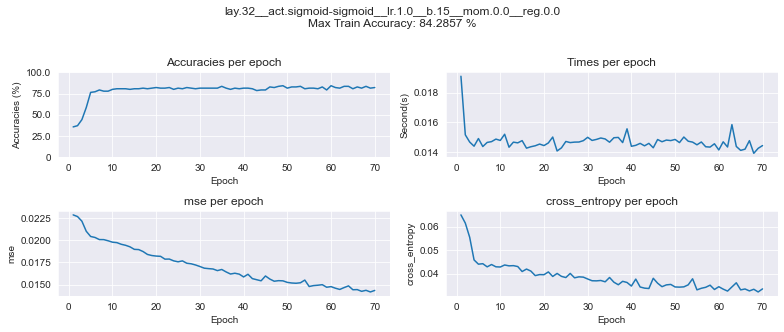

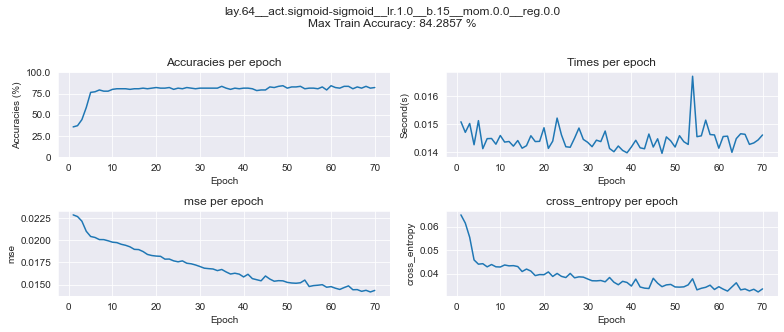

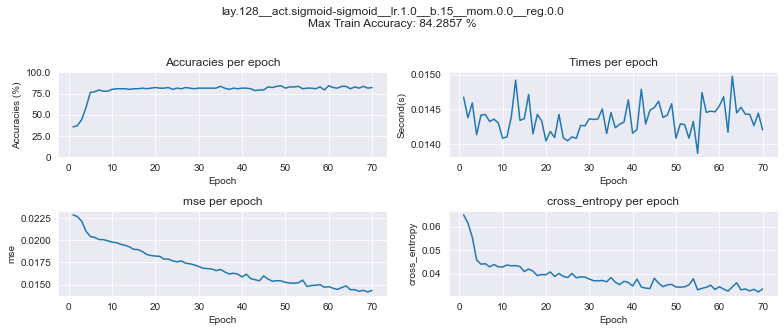

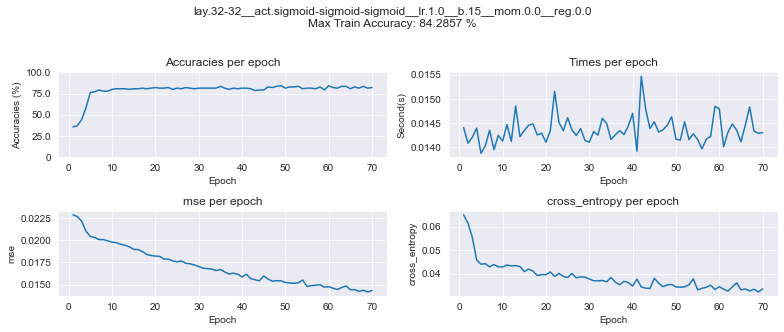

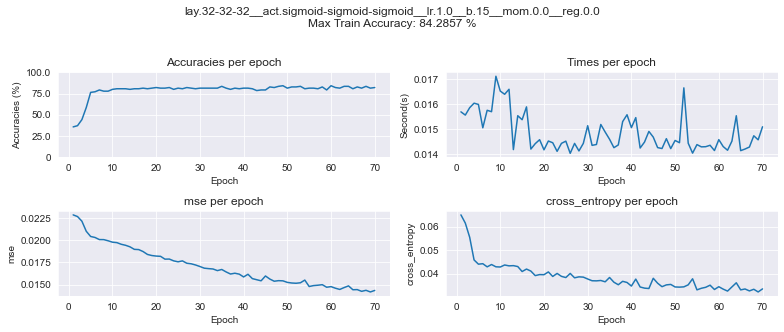

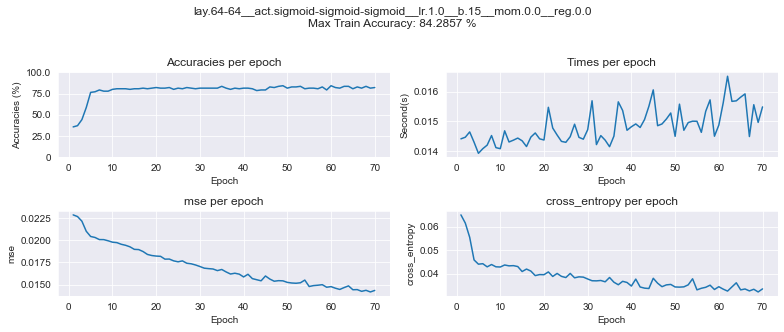

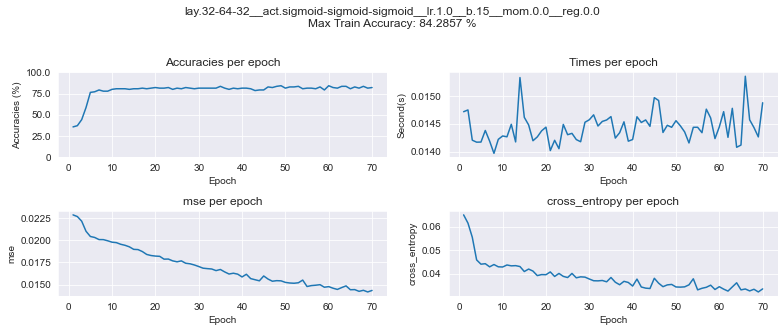

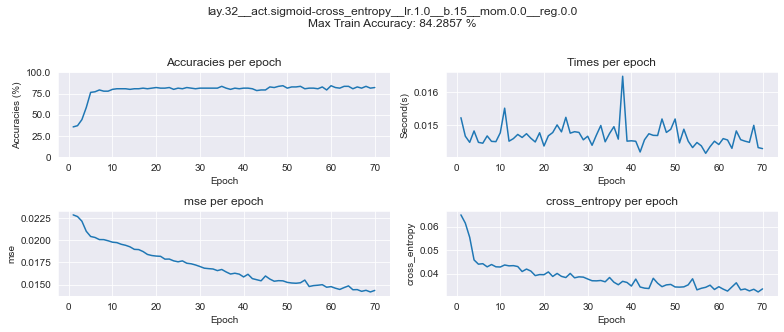

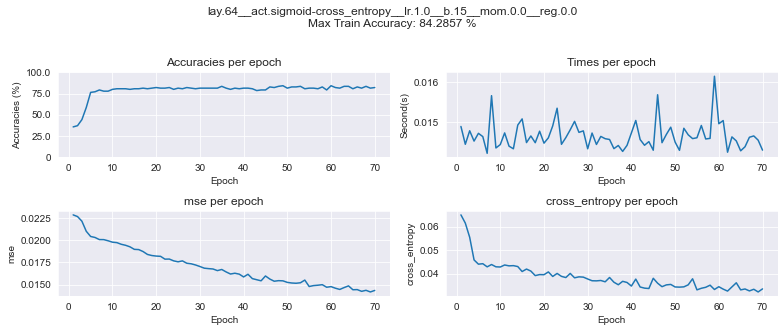

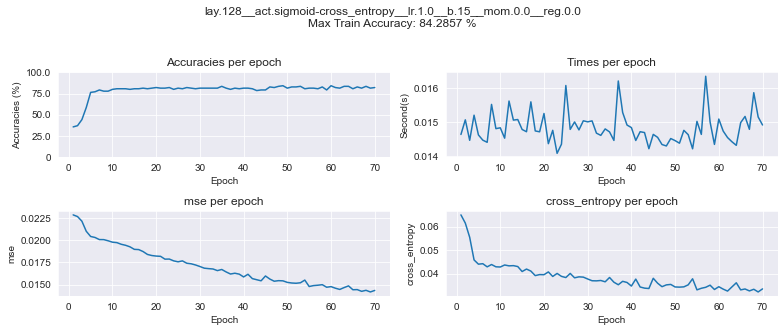

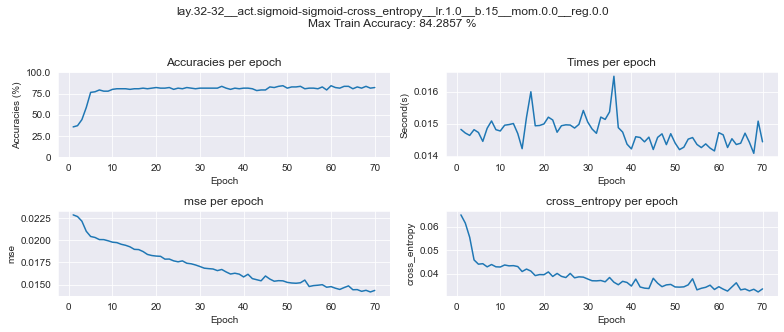

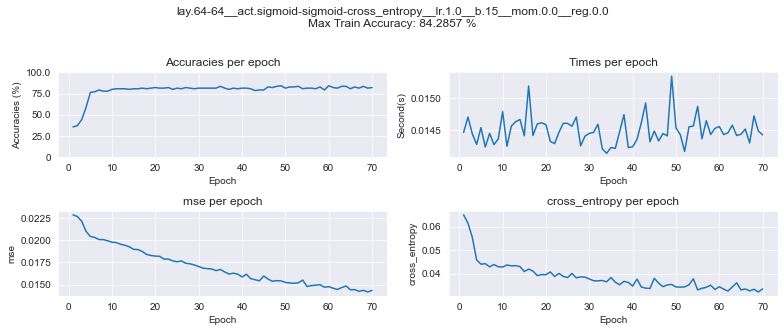

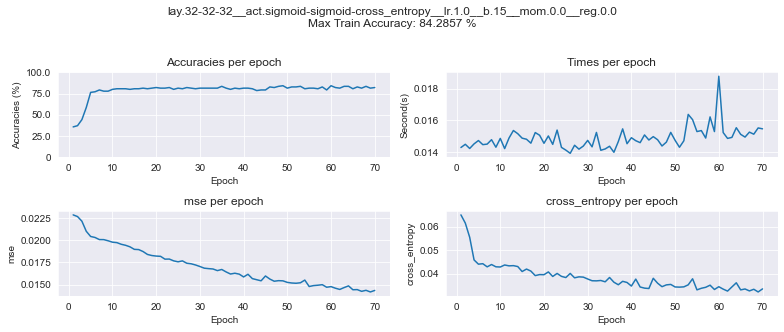

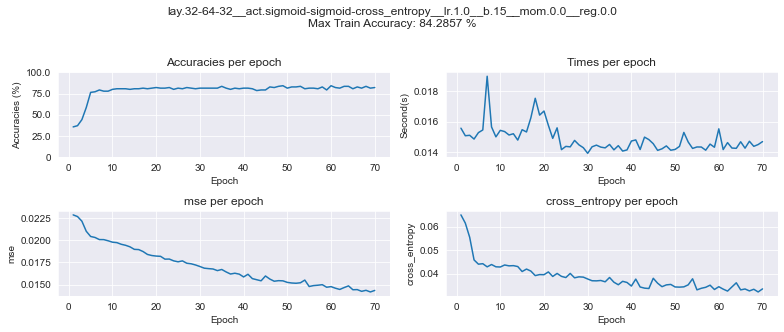

In [54]:
for name in pima_models:
    test_and_plot(title=name,
                  accuracies=pima_accuracies[name], 
                  losses=pima_losses[name], 
                  times=pima_times[name], 
                  subsample=1)

### Testing

In [142]:
subsample = 1

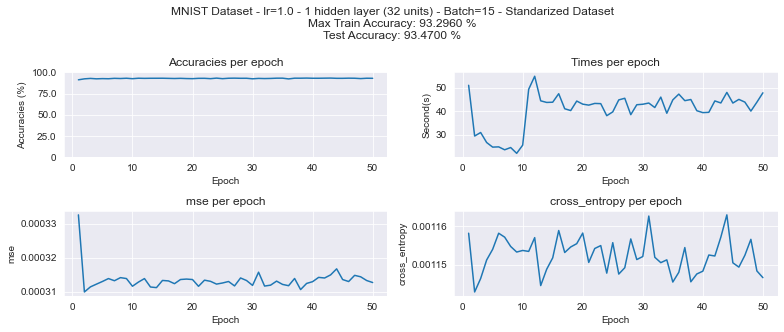

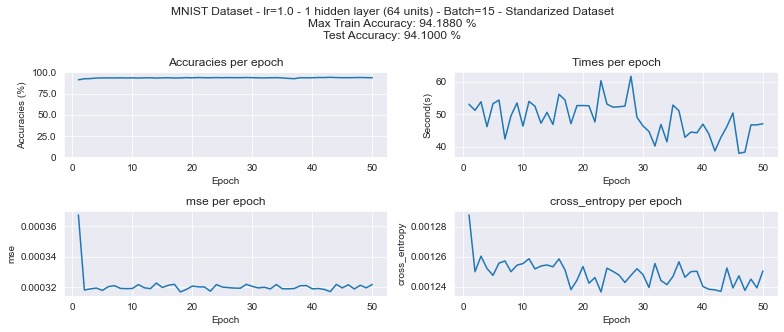

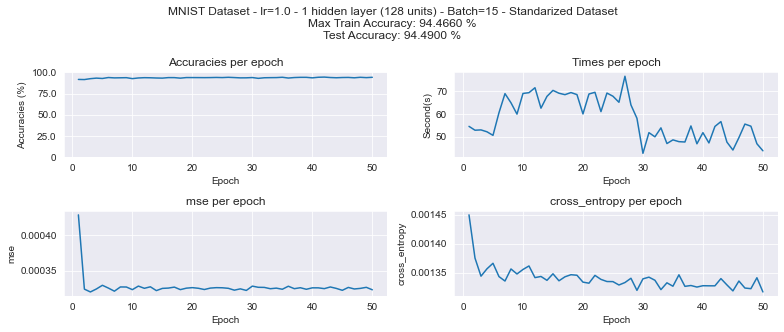

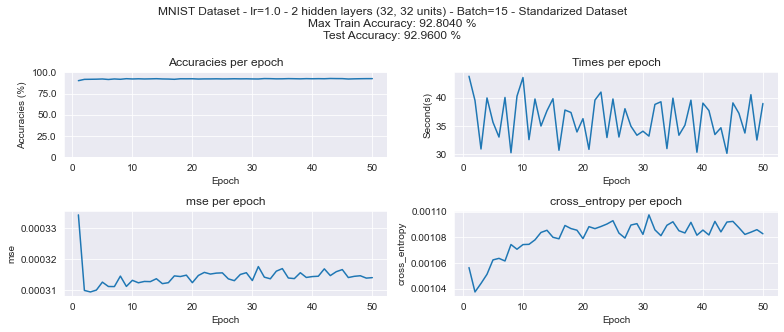

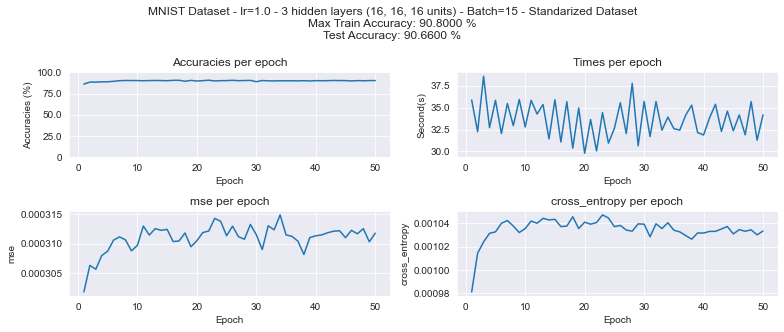

In [162]:
# Plot different the configurations for different Network Structures
name = "32__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
title = "MNIST Dataset - lr=1.0 - 1 hidden layer (32 units) - Batch=15 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

name = "64__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
title = "MNIST Dataset - lr=1.0 - 1 hidden layer (64 units) - Batch=15 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

name = "128__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
title = "MNIST Dataset - lr=1.0 - 1 hidden layer (128 units) - Batch=15 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

name = "32_32__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
title = "MNIST Dataset - lr=1.0 - 2 hidden layers (32, 32 units) - Batch=15 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

name = "16_16_16__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
title = "MNIST Dataset - lr=1.0 - 3 hidden layers (16, 16, 16 units) - Batch=15 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)